# Churn Prediction using Simple Neural Network

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow as tf
import os

C:\Users\dell\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Function to implement show_graph()

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# This module defines the show_graph() function to visualize a TensorFlow graph within Jupyter.

# As far as I can tell, this code was originally written by Alex Mordvintsev at:
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

# The original code only worked on Chrome (because of the use of <link rel="import"...>, but the version below
# uses Polyfill (copied from this StackOverflow answer: https://stackoverflow.com/a/41463991/38626)
# so that it can work on other browsers as well.


from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

### to make this notebook's output stable across runs

In [4]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Loading the Dataset

In [5]:
creditData = pd.read_csv("C:/Users/dell/Documents/HandsonDeepLearningwithTensorflow/Section 1-  Neural Networks in Tensorflow 2.0/dataset/ChurnBank.csv",encoding="utf-8",index_col=0)

### Data Dictionary

There are 25 variables:

1. <b>ID:</b> ID of each client  
2. <b>LIMIT_BAL:</b> Amount of given credit in NT dollars (includes individual and family/supplementary credit  
3. <b>SEX:</b> Gender (1=male, 2=female)  
4. <b>EDUCATION:</b> (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)  
5. <b>MARRIAGE:</b> Marital status (1=married, 2=single, 3=others)  
6. <b>AGE:</b> Age in years  
7. <b>PAY_0:</b> Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
8. <b>PAY_2:</b> Repayment status in August, 2005 (scale same as above)  
9. <b>PAY_3:</b> Repayment status in July, 2005 (scale same as above)  
10. <b>PAY_4:</b> Repayment status in June, 2005 (scale same as above)  
11. <b>PAY_5:</b> Repayment status in May, 2005 (scale same as above)  
12. <b>PAY_6:</b> Repayment status in April, 2005 (scale same as above)  
13. <b>BILL_AMT1:</b> Amount of bill statement in September, 2005 (NT dollar)  
14. <b>BILL_AMT2:</b> Amount of bill statement in August, 2005 (NT dollar)  
15. <b>BILL_AMT3:</b> Amount of bill statement in July, 2005 (NT dollar)  
16. <b>BILL_AMT4:</b> Amount of bill statement in June, 2005 (NT dollar)  
17. <b>BILL_AMT5:</b> Amount of bill statement in May, 2005 (NT dollar)  
18. <b>BILL_AMT6:</b> Amount of bill statement in April, 2005 (NT dollar)  
19. <b>PAY_AMT1:</b> Amount of previous payment in September, 2005 (NT dollar)  
20. <b>PAY_AMT2:</b> Amount of previous payment in August, 2005 (NT dollar)  
21. <b>PAY_AMT3:</b> Amount of previous payment in July, 2005 (NT dollar)  
22. <b>PAY_AMT4:</b> Amount of previous payment in June, 2005 (NT dollar)  
23. <b>PAY_AMT5:</b> Amount of previous payment in May, 2005 (NT dollar)  
24. <b>PAY_AMT6:</b> Amount of previous payment in April, 2005 (NT dollar)  
25. <b>default.payment.next.month:</b> Default payment (1=yes, 0=no)  

In [6]:
creditData.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Description of Dataframe

In [7]:
creditData.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### A look at column of Dataframe

In [8]:
creditCols = list(creditData.columns)
print(creditCols)

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month']


### Some bin plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7BC2ED908>,
      dtype=object)

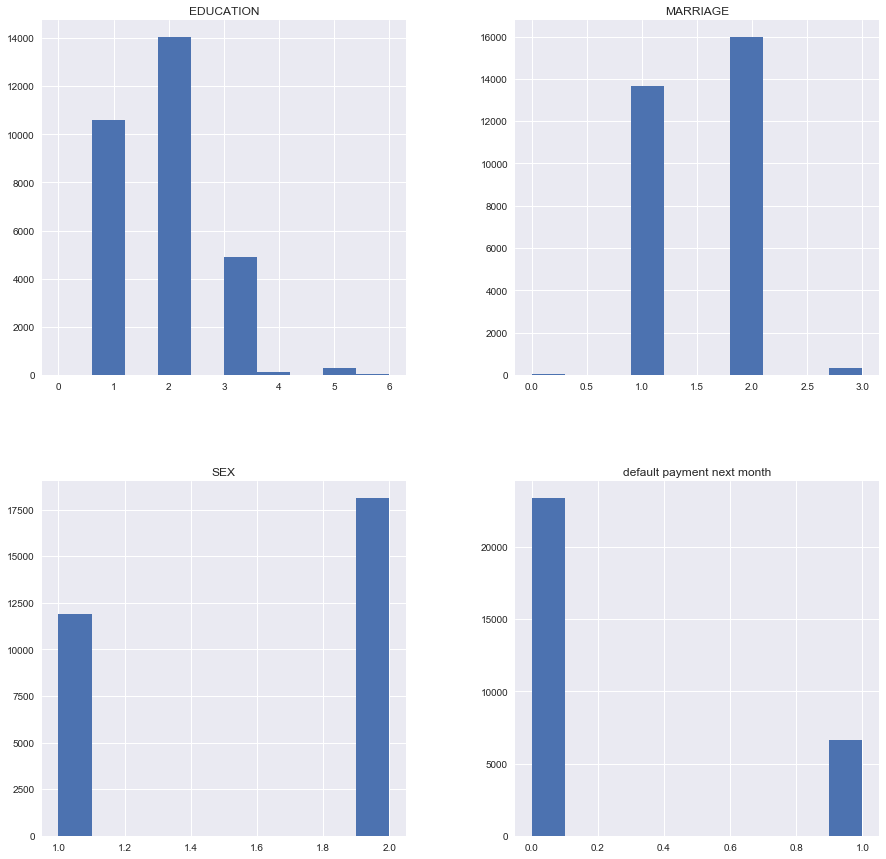

In [9]:
creditData[['SEX', 'EDUCATION', 'MARRIAGE','default payment next month']].hist(figsize=(15,15))

### CategoricalCols and ContinousCols 

In [10]:
categoricalCols = ["AGE_RANGE","SEX","EDUCATION","MARRIAGE"]
continuousCols = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

## Data Pre-processing

In [11]:
creditData.loc[creditData["SEX"]==2,"SEX"] = 0

ageGrps = list(range(20,85,5))
ageCrediters = pd.cut(creditData.AGE,ageGrps).to_frame()
ageCrediters.columns = ["AGE_RANGE"]
creditData = pd.concat([creditData,ageCrediters],axis=1)

creditData.AGE_RANGE = creditData.AGE_RANGE.astype('str')

### One hot Encoding

In [12]:
df = pd.get_dummies(creditData["MARRIAGE"])
df.columns = ['MARRIAGE_unk','MARRIAGE_married', 'MARRIAGE_single','MARRIAGE_others']
creditData = pd.concat([creditData,df],axis=1)

In [13]:
creditData["EDUCATION_grad"] = 0
creditData["EDUCATION_university"] = 0
creditData["EDUCATION_hs"] = 0
creditData["EDUCATION_others"] = 0
creditData["EDUCATION_ukn"] = 0
creditData.loc[creditData["EDUCATION"]==1,"EDUCATION_grad"] = 1
creditData.loc[creditData["EDUCATION"]==2,"EDUCATION_university"] = 1
creditData.loc[creditData["EDUCATION"]==3,"EDUCATION_hs"] = 1
creditData.loc[creditData["EDUCATION"]==4,"EDUCATION_others"] = 1
creditData.loc[creditData["EDUCATION"]==5,"EDUCATION_ukn"] = 1
creditData.loc[creditData["EDUCATION"]==0,"EDUCATION_ukn"] = 1
creditData.loc[creditData["EDUCATION"]==6,"EDUCATION_ukn"] = 1


In [14]:
df = pd.get_dummies(creditData.AGE_RANGE)
df.columns = ['AGE_(20, 25]', 'AGE_(25, 30]', 'AGE_(30, 35]', 'AGE_(35, 40]', 'AGE_(40, 45]', 'AGE_(45, 50]','AGE_(50, 55]', 'AGE_(55, 60]', 'AGE_(60, 65]', 'AGE_(65, 70]', 'AGE_(70, 75]', 'AGE_(75, 80]']
creditData = pd.concat([creditData,df],axis=1)

## Standardization

In [15]:
from sklearn.preprocessing import StandardScaler
creditData.loc[:, continuousCols] = StandardScaler().fit_transform(creditData.loc[:, continuousCols].values)

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
features = ['LIMIT_BAL', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'MARRIAGE_unk', 'MARRIAGE_married',
        'EDUCATION_grad',
       'EDUCATION_university', 'EDUCATION_others',
       'EDUCATION_ukn', 'AGE_(20, 25]', 'AGE_(25, 30]',
       'AGE_(30, 35]', 'AGE_(35, 40]', 'AGE_(40, 45]', 'AGE_(45, 50]',
       'AGE_(50, 55]', 'AGE_(55, 60]', 'AGE_(60, 65]', 'AGE_(65, 70]',
       'AGE_(70, 75]']

## Prepping Data for Model

In [17]:
data = creditData[features+["default payment next month"]]

In [18]:
trainData = data.sample(frac=.70) # random sampling of 70 of data
testData = data.loc[set(data.index)- set(trainData.index)] # picking the rest 30% of the data

## Training of Neural Network Model with Tensorflow

In [19]:
XTrain = trainData[features].values
TTrain = trainData["default payment next month"].values
XTest = testData[features].values
TTest = testData["default payment next month"].values

### A Simple Neural Network Model

In [20]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 5
n_hidden2 = 5
n_hidden3 = 5
n_hidden4 = 5
n_hidden5 = 5
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.tanh, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.tanh, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.tanh, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.tanh, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.tanh, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Graphical view of Neural Network Model

In [21]:
show_graph(tf.get_default_graph())

## Neural Network in Action

In [22]:
n_epochs=3000
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if(epoch%100==0):
            print("Test Accuracy after " +str(epoch) + " epoch: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Accuracy after " +str(n_epochs) + " epoch: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Accuracy after 0 epoch:  0.4531111
Test Accuracy after 100 epoch:  0.7726667
Test Accuracy after 200 epoch:  0.7726667
Test Accuracy after 300 epoch:  0.7726667
Test Accuracy after 400 epoch:  0.7726667
Test Accuracy after 500 epoch:  0.7726667
Test Accuracy after 600 epoch:  0.7726667
Test Accuracy after 700 epoch:  0.7726667
Test Accuracy after 800 epoch:  0.77988887
Test Accuracy after 900 epoch:  0.7868889
Test Accuracy after 1000 epoch:  0.7927778
Test Accuracy after 1100 epoch:  0.7991111
Test Accuracy after 1200 epoch:  0.80266666
Test Accuracy after 1300 epoch:  0.8053333
Test Accuracy after 1400 epoch:  0.8061111
Test Accuracy after 1500 epoch:  0.80833334
Test Accuracy after 1600 epoch:  0.8091111
Test Accuracy after 1700 epoch:  0.8107778
Test Accuracy after 1800 epoch:  0.81133336
Test Accuracy after 1900 epoch:  0.81166667
Test Accuracy after 2000 epoch:  0.81211114
Test Accuracy after 2100 epoch:  0.81255555
Test Accuracy after 2200 epoch:  0.8131111
Test Accuracy af

## Loss and Accuracy Plots

Text(0,0.5,'Accuracy Ratio')

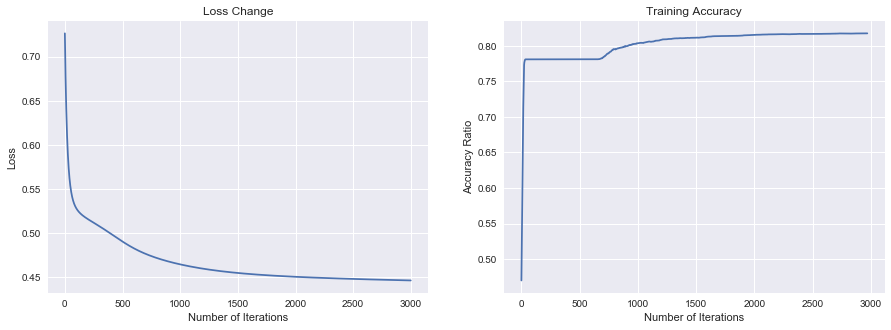

In [135]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

## End